# Image Segmentation

Sayyidan Muhamad Ikhsan <br>
20/460160/TK/50749 <br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, cv2

# Load image
images = []
file_path = ("/content/drive/MyDrive/SP Image Processing/DRIONS-DB/Data/")
files = sorted(os.listdir("//content/drive/MyDrive/SP Image Processing/DRIONS-DB/Data/"))
for file in files:
  img0 = cv2.imread(file_path+file)
  img = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY) #Konversi ke citra grayscale
  images.append(img)

# Load ground truth
truth_images = []
truth_img_file = []
file_path = ("//content/drive/MyDrive/SP Image Processing/DRIONS-DB/Ground Truth/")
files = sorted(os.listdir("//content/drive/MyDrive/SP Image Processing/DRIONS-DB/Ground Truth/"))
for file in files:
  img0 = cv2.imread(file_path + file)
  img = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY) #Konversi ke citra grayscale
  truth_images.append(img)

##Checking image

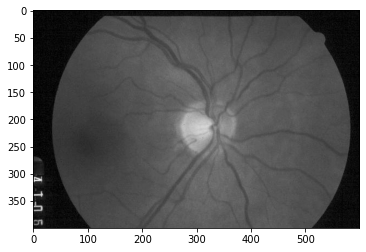

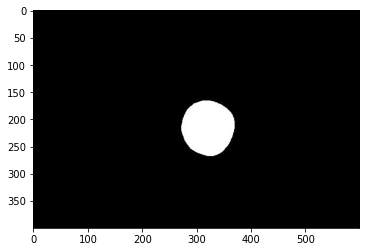

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(images[4], cmap="gray")
plt.figure()
plt.imshow(truth_images[4], cmap="gray")

In [ ]:
#resolusi citra
wid,hgt=images[4].shape

#displaying the dimensions
print('resolusi citra',str(wid)+"x"+str(hgt))
print('')
#matriks citra
print('matriks citra')
print(images[4])

resolusi citra 400x600

matriks citra
[[ 0 12  3 ...  2  1  1]
 [ 7 18  8 ... 10 10 11]
 [ 4 11  5 ...  1  4  8]
 ...
 [20  4  8 ... 13 18 12]
 [27 14 10 ... 10 19 16]
 [23 23 24 ... 13 13  3]]


##U-Net

In [ ]:
import tensorflow as tf
from keras.layers.core import Lambda
def encoder_2DUnet(input_layer, feature_num):
  # Konvolusi dengan jumlah dengan ukuran kernel 3x3 dan fungsi aktivasi relu
  conv1 = tf.keras.layers.Conv2D(feature_num, (3,3), activation="relu",padding='same', kernel_initializer="he_normal")(input_layer)
  bnm1 = tf.keras.layers.BatchNormalization()(conv1)
  conv2 = tf.keras.layers.Conv2D(feature_num, (3,3), activation="relu",padding='same', kernel_initializer="he_normal")(bnm1)
  bnm2 = tf.keras.layers.BatchNormalization()(conv2)
  # Max pooling dengan ukuran 2x2
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
  return pool, bnm2

def decoder_2DUnet(input_layer, concatenate_layer, feature_num):
  # Transpose Convolution dengan strides 2x2
  up1 = tf.keras.layers.Conv2DTranspose(feature_num, 2, strides=(2,2),padding='same')(input_layer)
  # Operasi concatenate
  merge = tf.keras.layers.concatenate([concatenate_layer, up1])
  # Konvolusi dengan jumlah dengan ukuran kernel 3x3 dan fungsi aktivasi relu
  conv1 = tf.keras.layers.Conv2D(feature_num, (3,3), activation="relu",padding='same', kernel_initializer="he_normal")(merge)
  conv2 = tf.keras.layers.Conv2D(feature_num, (3,3), activation="relu",padding='same', kernel_initializer="he_normal")(conv1)
  return conv2

def double_conv_block(input_layer, n_filters):
   # Conv2D then ReLU activation
   input_layer = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(input_layer)
   # Conv2D then ReLU activation
   #input_layer = tf.keras.layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu", kernel_initializer = "he_normal")(input_layer)
   return input_layer

def Unet2D(shape_x = 256, shape_y = 256):
  inputs = tf.keras.Input((shape_x, shape_y, 1))
  s = Lambda(lambda x: x / 255) (inputs)

  #Pada U-Net ada operasi maxpooling sebanyak 4 kali, agar ukuran fitur tetap genap
  #maka perlu diatur sehingga ukuran citra merupakan kelipatan 16
  zp = tf.keras.layers.ZeroPadding2D(padding=((0,0),(4,4))) (s)
  #Bagian operasi encoder dengan jumlah feature map tertentu
  enc_1, conv_1 = encoder_2DUnet(zp, 64)
  enc_2, conv_2 = encoder_2DUnet(enc_1, 128)
  enc_3, conv_3 = encoder_2DUnet(enc_2, 256)
  enc_4, conv_4 = encoder_2DUnet(enc_3, 512)

  ##  TAMBAH MODEL ##
  bottleneck = double_conv_block(enc_4, 1024)

  conv_6 = decoder_2DUnet(bottleneck, conv_4, 512)
  conv_7 = decoder_2DUnet(conv_6, conv_3, 256)
  conv_8 = decoder_2DUnet(conv_7, conv_2, 128)
  conv_9 = decoder_2DUnet(conv_8, conv_1, 64)

  y = tf.keras.layers.Cropping2D(cropping=((0, 0), (4, 4)))(conv_9)
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(y)
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name="U-net")
  return model

##Pre-processing

In [ ]:
def preprocess(x, y):
  x = tf.expand_dims(x, axis=-1)
  y = float(y)/255.0
  return x, y

In [ ]:
from sklearn.model_selection import train_test_split

img_train, img_valtest, t_img_train, t_img_valtest = train_test_split(images, truth_images, train_size = 0.6, test_size = 0.4)
img_val, img_test, t_img_val, t_img_test = train_test_split(img_valtest, t_img_valtest, train_size = 0.5, test_size = 0.5)
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, t_img_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((img_val, t_img_val))
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, t_img_test))
train_datagen = (train_dataset.shuffle(len(img_train)).map(preprocess).batch(8))
validation_datagen = (validation_dataset.shuffle(len(img_val)).map(preprocess).batch(8))
test_datagen = (test_dataset.shuffle(len(img_test)).map(preprocess).batch(1))

In [ ]:
from keras import backend as K
smooth = 1

def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

##Training Data

In [ ]:
model = Unet2D(400, 600) #Citra yang digunakan memiliki resolusi 400x600
model.compile(loss=dice_coef_loss,optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0003),
metrics=[tf.metrics.BinaryAccuracy(), dice_coef, tf.metrics.Recall(), tf.metrics.Precision()],)
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 3,restore_best_weights = True)
history = model.fit(train_datagen,validation_data = validation_datagen,verbose = 1,callbacks = early_stop,epochs = 10)

Epoch 1/10
9/9 [==============================] - 67s 4s/step - loss: 0.6612 - binary_accuracy: 0.8528 - dice_coef: 0.3383 - recall: 0.6760 - precision: 0.1450 - val_loss: 0.9218 - val_binary_accuracy: 0.2169 - val_dice_coef: 0.0782 - val_recall: 1.0000 - val_precision: 0.0399
Epoch 2/10
9/9 [==============================] - 14s 2s/step - loss: 0.3634 - binary_accuracy: 0.9708 - dice_coef: 0.6546 - recall: 0.6635 - precision: 0.5878 - val_loss: 0.8874 - val_binary_accuracy: 0.4472 - val_dice_coef: 0.1105 - val_recall: 1.0000 - val_precision: 0.0557
Epoch 3/10
9/9 [==============================] - 15s 2s/step - loss: 0.2448 - binary_accuracy: 0.9823 - dice_coef: 0.7633 - recall: 0.7038 - precision: 0.8165 - val_loss: 0.7518 - val_binary_accuracy: 0.8005 - val_dice_coef: 0.2435 - val_recall: 0.9745 - val_precision: 0.1399
Epoch 4/10
9/9 [==============================] - 14s 2s/step - loss: 0.2162 - binary_accuracy: 0.9839 - dice_coef: 0.7952 - recall: 0.7413 - precision: 0.8415 - val_

##Evaluate Model

In [ ]:
x = model.evaluate(test_datagen)

22/22 [==============================] - 4s 78ms/step - loss: 0.3637 - binary_accuracy: 0.9698 - dice_coef: 0.6363 - recall: 0.6082 - precision: 0.5507


Prediksi

In [ ]:
img = tf.expand_dims(img_train[26], axis=-0)
t_img = tf.expand_dims(t_img_train[26], axis=0)
test_set = tf.data.Dataset.from_tensor_slices((img, t_img))
test_gen = (test_set.map(preprocess).batch(1))
pred = model.predict(test_gen)

1/1 [==============================] - 1s 556ms/step


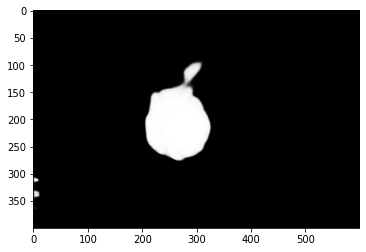

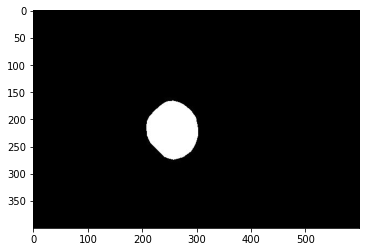

In [ ]:
plt.figure()
plt.imshow(pred[0,:,:,0], cmap="gray")
plt.figure()
plt.imshow(t_img[0,:,:], cmap="gray")

In [ ]:
model.summary()

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 600, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 400, 600, 1)  0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 400, 608, 1)  0          ['lambda[0][0]']                 
                                                                                                  
 conv2d (Conv2D)                (None, 400, 608, 64  640         ['zero_padding2d[0][0]']     